# CSE 144 Fall 2023 HW 1

In this assignment, the goal is to build a linear regression model to predict the song popularity based on energy, acoustics, instumentalness, liveness, dancibility, etc. We'll be using the [Song Popularity Dataset](https://www.kaggle.com/datasets/yasserh/song-popularity-dataset) dataset from Kaggle dataset.

In the first section, you'll perform standard data preprocessing using techniques we covered in class, including binning, one-hot encoding, feature crossing, and normalization. In the second section, you'll train a simple linear regression model to predict the song popularity

## Instruction 

- Submit your assignments onto **Canvas** by the due date.
- This is an **individual** assignment. All help from others (from the web, books other than text, or people other than the TA or instructor) must be clearly acknowledged. 
- Don't change the input and output structure of pre-defined functions. Most coding parts can be finished with about 5-6 lines of codes. 
- You should be able to use NumPy, Pandas, and the `train_test_split()` function from scikit-learn to complete everything in this assignment. We also imported Matplotlib for you to visualize the training and validation loss.
- Remember that tuning on the test loss is prohibited.

## Rubric

The assignment is worth 50 (47+3) points in total:
- Data preprocessing (12 points)
    - drop missing values (2 points)
    - drop outliers (5 points)
    - normalization (5 points)
- Dataset split (10 points)
    - test set split (5 points)
    - k-fold train and validation set split (5 points)
- Linear regression (25 points)
    - MSE_loss (3 points)
    - Gradient (5 points)
    - Theta initialization (3 points)
    - Translate dataframe to numpy (3 points)
    - Traininig (5 points)
        - Save train and val loss (2 points)
        - Update parameters (3 points)
    - Find best parameters (3 points)
    - Evaluate on test set (3 points)

- Bonus (3 points)
    - If your test loss is below 0.025

In [1]:
!python3 --version

Python 3.11.4


In [2]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
seed = 144
random.seed(seed)
np.random.seed(seed)

print(seed)

144


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB
0        0.000029
1        0.000000
2        0.447000
3        0.003550
4        0.000000

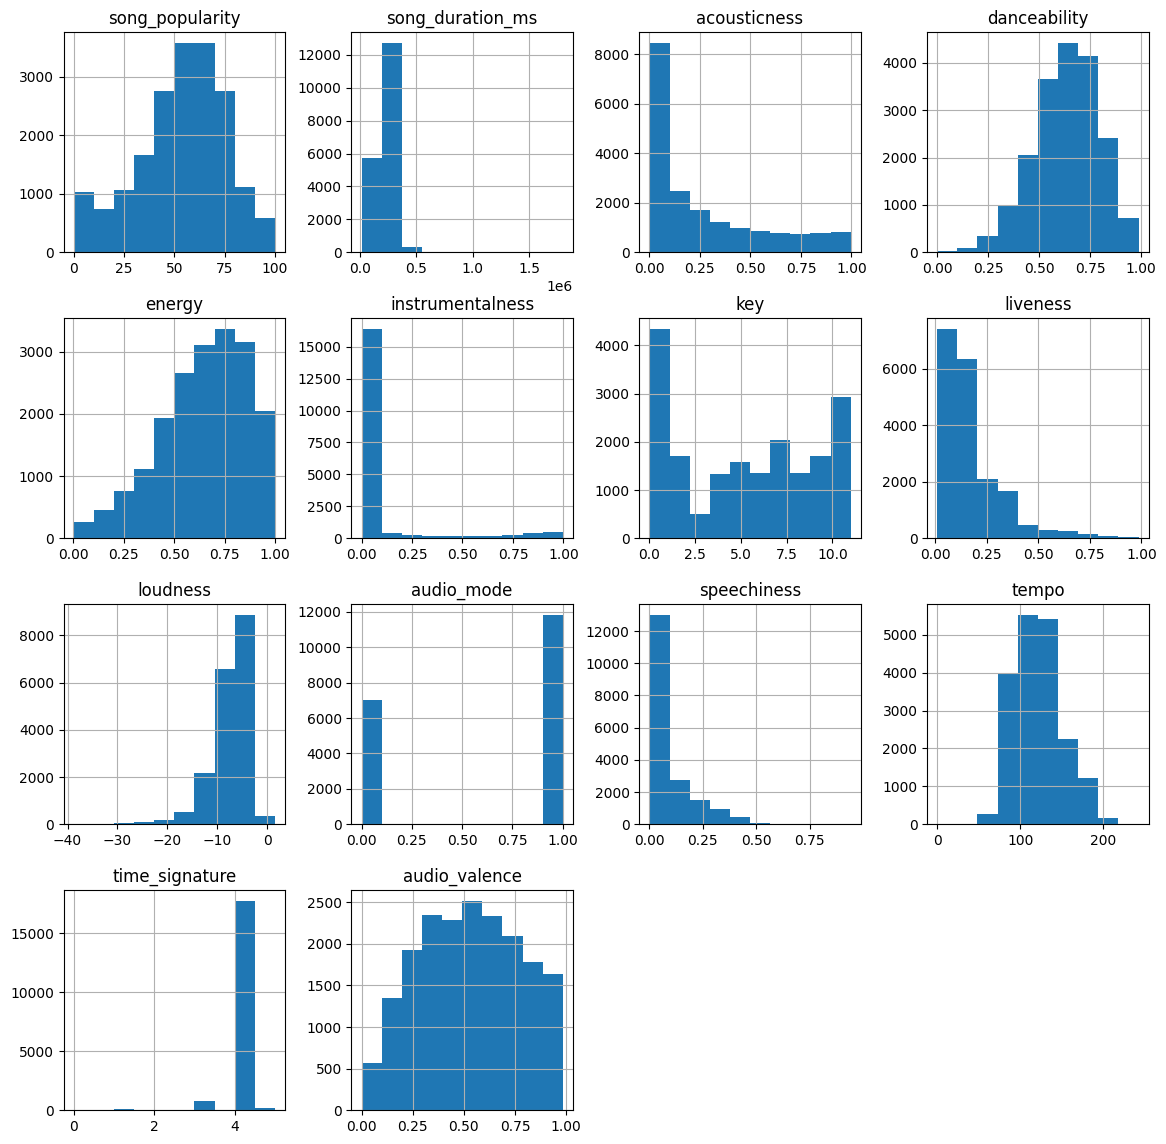

In [36]:
# Load data
data = pd.read_csv("./song_data.csv").drop(["song_name"], axis = 1)

# Visualize data
df = pd.DataFrame(data)
df.info()
df.hist(figsize=(14,14))

print(df['instrumentalness'])


### Data Cleaning
`data.info()` shows that there are some missing values in the dataset. Also, we can see from the histogram that outliers exist for some features. Moreover, the range of different features has a huge gap: most in (0,1), but some are on the order of 1e2, or even 1e5. In the following you need to perform:
1. Drop rows that contain NULL values.
2. Remove outliers for features in ['song_duration_ms', 'instrumentalness'] based on interquantile range.
3. Scale ranges of independent variables using Z-score method, and normalize the range of dependent feature ['song_popularity'] from [0,100] to [0,1]

In [62]:
# drop rows that have NULL value
# ========== YOUR CODE STARTS HERE ==========
# used this resources: https://saturncloud.io/blog/how-to-delete-rows-with-null-values-in-a-specific-column-in-pandas-dataframe/#:~:text=Deleting%20rows%20with%20null%20values%20in%20a%20specific%20column%20can,()%20method%20of%20Pandas%20DataFrame.

for subset in df:
    df.dropna()

# ========== YOUR CODE ENDS HERE ============

'''
Remove outliers for features in ['song_duration_ms', 'instrumentalness', 'time_signature'] 
based on interquantile range. Here for each feature, we first sort data in an ascending order.
Let q1 and q3 be the data that ranks 25% and 75% respectively. We then let iqr = q3 - q1, and 
compute 
                a = q1 - iqr x 1.5,
                b = q3 + iqr x 1.5,
and remove the data out of the range [a, b].
Note: this can be realized with function quantile().
'''

for feature in ['song_duration_ms', 'instrumentalness', 'time_signature']:
    # ========== YOUR CODE STARTS HERE ==========
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Determine the lower and upper bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers based on the calculated bounds
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    # ========== YOUR CODE ENDS HERE ============
    
df = df.reset_index(drop=True)
print('here is data cleaned\n', df)


'''
Scale all features using z-score normalization. 
Note: use different column and std for different columns!
'''
# ========== YOUR CODE STARTS HERE ==========
#  I used this resource I found during how to use the zscore formula: https://datagy.io/python-z-score/
# import scipy.stats as stats

z_scores = df.apply(lambda x: (x - x.mean()) / x.std())
print('here are z scores\n', z_scores)

data = z_scores
# ========== YOUR CODE ENDS HERE ============

here is data cleaned
       song_popularity  song_duration_ms  acousticness  danceability  energy  \
0                  66            216933      0.010300         0.542   0.853   
1                  56            223826      0.000954         0.447   0.766   
2                  80            222586      0.001080         0.330   0.936   
3                  78            168253      0.042400         0.629   0.897   
4                  63            185586      0.004600         0.496   0.863   
...               ...               ...           ...           ...     ...   
6519               61            199853      0.627000         0.658   0.396   
6520               62            256875      0.690000         0.641   0.415   
6521               40            206522      0.570000         0.651   0.261   
6522               62            195106      0.395000         0.644   0.523   
6523               23            182211      0.847000         0.719   0.325   

      instrumentalness  key  

Now we visualize the data again.

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
6519   NaN
6520   NaN
6521   NaN
6522   NaN
6523   NaN
Name: instrumentalness, Length: 6524, dtype: float64
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
6519   NaN
6520   NaN
6521   NaN
6522   NaN
6523   NaN
Name: time_signature, Length: 6524, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6524 entries, 0 to 6523
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   6524 non-null   float64
 1   song_duration_ms  6524 non-null   float64
 2   acousticness      6524 non-null   float64
 3   danceability      6524 non-null   float64
 4   energy            6524 non-null   float64
 5   instrumentalness  0 non-null      float64
 6   key               6524 non-null   float64
 7   liveness          6524 non-null   float64
 8   loudness          6524 non-null   float64
 9   audio_mode        6524 no

array([[<Axes: title={'center': 'song_popularity'}>,
        <Axes: title={'center': 'song_duration_ms'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'audio_mode'}>,
        <Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'tempo'}>],
       [<Axes: title={'center': 'time_signature'}>,
        <Axes: title={'center': 'audio_valence'}>, <Axes: >, <Axes: >]],
      dtype=object)

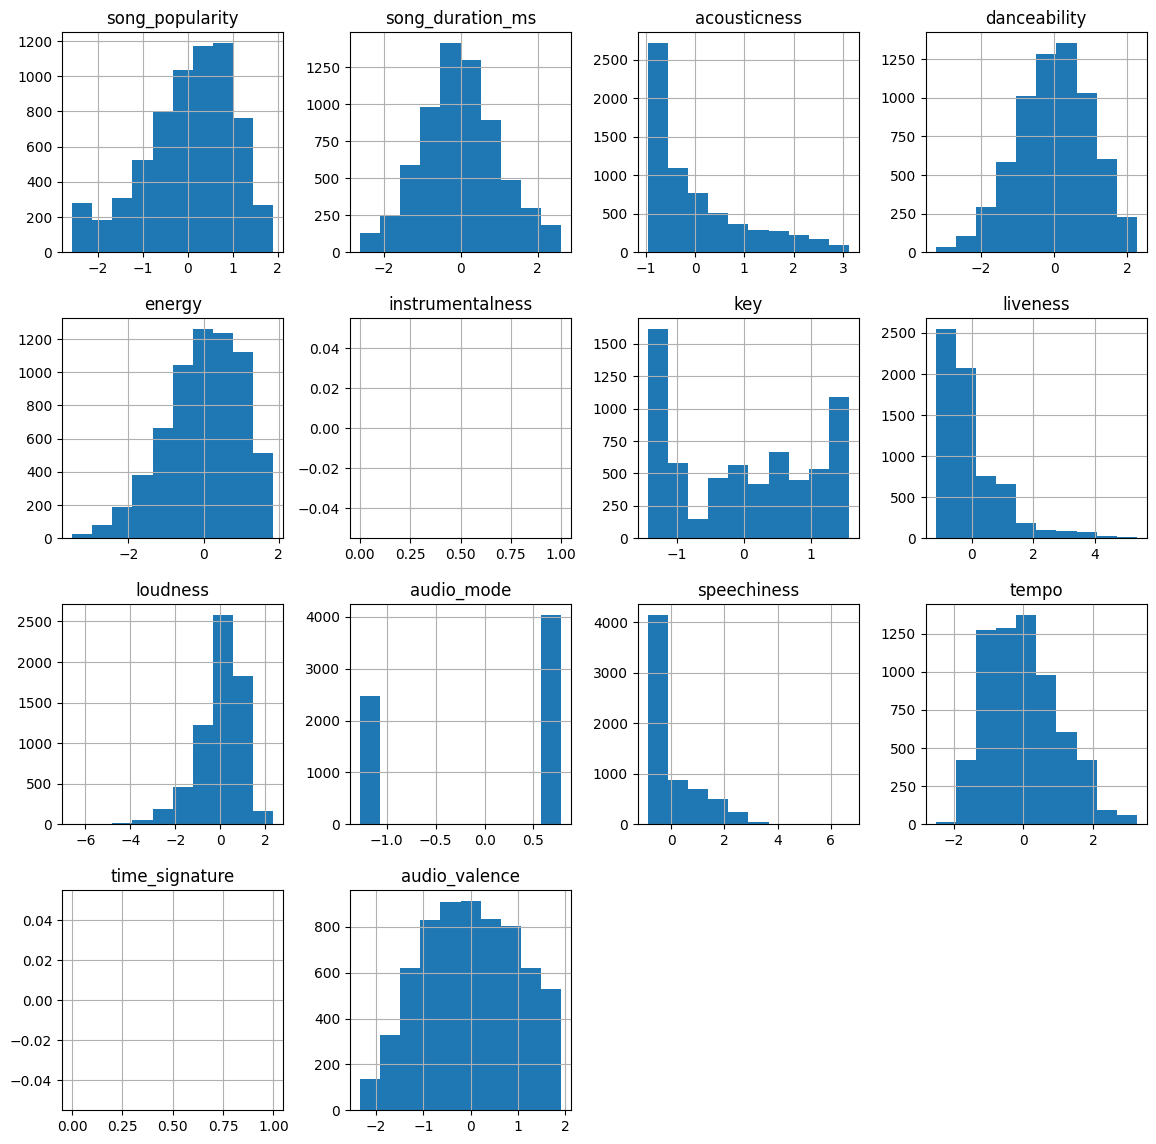

In [59]:
print(data['instrumentalness'])
print(data['time_signature'])

data.info()
data.hist(figsize=(14,14))

## Dataset preparation
Next we will split dataset to train set, validation set and test set. First we randomly choose 30% as test set. Then we use $k$-fold validation on the remaining 70% to generate $k$ different train set and validation set pairs, where $k=5$.

In [ ]:
def test_split(data, test_size: float=0.3, seed=seed):
    """
    Use function train_test_split() to split test set.
    """
    # ========== YOUR CODE STARTS HERE ==========
    X = data[]
    y = data[]

    X_train_val, y_train_val, X_test, y_test = train_test_split(X, y, random_state=104, train_size=test_size, shuffle=True)

    # ========== YOUR CODE ENDS HERE ============
    
    return (X_train_val.reset_index(drop=True),
            y_train_val.reset_index(drop=True),
            X_test.reset_index(drop=True),
            y_test.reset_index(drop=True))
    

def train_val_split(X_train_val, y_train_val, k=5, seed=seed):
    """
    Use given index sets to generate k train and validation pairs. The return value should be 
    a list whose components are tuples:
    [(X_train1, y_train1, X_val1, y_val1), ..., (X_traink, y_traink, X_valk, y_valk)]
    
    Here suppose data length is 10, the index sets could be like:
                    [[2,5], [1,6], [3,8], [9,4], [0,7]]
    
    """
    index_shuffle = list(X_train_val.index)
    random.shuffle(index_shuffle)
    index_split_list = [[index_shuffle[i+j] for i in range(0, len(index_shuffle), 5)  if i+j<len(index_shuffle)] for j in range(5)]
    train_val_pairs = [0 for i in range(k)]
    # ========== YOUR CODE STARTS HERE ==========
    
    # ========== YOUR CODE ENDS HERE ============    
    return train_val_pairs

X_train_val, y_train_val, X_test, y_test = test_split(data)
train_val_pairs = train_val_split(X_train_val, y_train_val)

In [ ]:
def MSE_loss(pred: np.ndarray, target: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ============ 

def gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ============ 


num_epochs = 5000
learning_rate = 1e-3
k = 5
train_loss_history = [[] for _ in range(k)]
val_loss_history = [[] for _ in range(k)]

theta_min = None
index_min = None
loss_min = None

for i in range(k):
    X_train, y_train, X_val, y_val = train_val_pairs[i]
    
    # Translate dataframe to numpy     
    # ========== YOUR CODE STARTS HERE ==========
    # ========== YOUR CODE ENDS HERE ============
    
    # Initialize theta    
    # ========== YOUR CODE STARTS HERE ==========
    # ========== YOUR CODE ENDS HERE ============
    
    for epoch in range(num_epochs):
        # Compute loss, and save to train_loss_history and val_loss_history
        # ========== YOUR CODE STARTS HERE ==========
        continue
        # ========== YOUR CODE ENDS HERE ============
        
        # Update parameter
        # ========== YOUR CODE STARTS HERE ==========
        # ========== YOUR CODE ENDS HERE ============

    
    # Inference on validation set, and fine the best parameters. Save corresponding parameters and index in theta_min and  index_min
    # ========== YOUR CODE STARTS HERE ==========
    # ========== YOUR CODE ENDS HERE ============


print(f"Final train loss for the best model: {train_loss_history[index_min][-1]}")
print(f"Final validation loss for the best model: {val_loss_history[index_min][-1]}")
print(theta_min)

plt.plot(np.arange(num_epochs), train_loss_history[index_min], label="Train loss")
plt.plot(np.arange(num_epochs), val_loss_history[index_min], label="Val loss")
plt.title("Train + validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Evaluate on test set
# ========== YOUR CODE STARTS HERE ==========
# ========== YOUR CODE ENDS HERE ============                  
print(f"Test loss: {test_loss}")